<a href="https://colab.research.google.com/github/JotaBlanco/F1_Data/blob/main/F1_Lapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Lapping
Based on periodicity of data, guess if a car is lapping and if so, predict when is next braking event happening.

## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 0103 Load Datasets
Data can be found ([here](https://github.com/MrPranz/F1-Telemetry)). 
https://github.com/MrPranz/F1-Telemetry

In [2]:
import csv
import numpy as np

def processtelemetry(csvfile,thrcut=1,brkcut=1,tb=False):
	# inputs:
	# csvfile = csv file as string
	# thrcut = normalised cut off value for throttle data. Sets this value as the max instead of the true max.
	# brkcut = normalised cut off value for brake data. Sets this value as the max instead of the true max.
	# tb = True if csv file has throttle/brake data, boolean.

	# outputs: 
	# v = 1d array of velocity
	# f = 1d array of time
	# d = 1d array of distance
	# [dtb,thr,brk] = array of 3x1d arrays of distance, throttle, and brake

	# read csv file
	with open(csvfile,'r') as file:
		reader = csv.reader(file)
		v_ocr,t_ocr,thr_ocr,brk_ocr = list(reader)

	v_all = []
	t_all = []
	thr_all = []
	brk_all = []

	# since the raw output from ocr is not always numeric, its converted to floats here where possible
	for j in range(0,len(v_ocr),1):
		try:
			vj = [float(v_ocr[j])]
			tj = [float(t_ocr[j])]
		except ValueError:
			vj = [-1]
			tj = [t_ocr[j]]
		v_all = v_all + vj
		t_all = t_all + tj
		if tb == True:
			try:
				thr_all = thr_all + [thr_ocr[j]]
				brk_all = brk_all + [brk_ocr[j]]
			except IndexError:
				pass

	# find and remove odd speed values
	kidx = []
	for k in range(len(v_all)):
		if v_all[k] == -1 or v_all[k] > 400 or v_all[k] < 30:
			kidx = kidx + [k]
	vc1 = np.delete(v_all,kidx)
	tc1 = np.delete(t_all,kidx)
	thr = np.delete(thr_all,kidx).astype(float)
	brk = np.delete(brk_all,kidx).astype(float)
	v,t = vc1,tc1

	# create distance array for throttle and brake traces
	dtb = np.array([0])
	tc1 = tc1.astype(float)
	for s in range(0,len(vc1)-1):
		dtbi = (vc1[s]+vc1[s+1])*(tc1[s+1]-tc1[s])*0.5/3.6
		dtb = np.append(dtb,dtbi+dtb[s])

	# create distance array for velocity trace
	d = np.array([0])
	t = t.astype(float)
	for n in range(len(v)-1):
		di = (v[n]+v[n+1])*(t[n+1]-t[n])*0.5/3.6
		d = np.append(d,di+d[n]) 

	# Since the throttle and brake data is the pixel count, these are normalised and converted. 
	# Pixel counts can vary a lot so thrcut and brkcut serve to fix this. For thrcut, it also serves
	# to remove the DRS addition of green pixels. 
	if tb:
		thrmax = max(np.extract(thr < thrcut*max(thr),thr))
		brkmax = max(np.extract(brk < brkcut*max(brk),brk))

		for i in range(len(thr)):
			if thr[i] > thrmax:
				thr[i] = thrmax
			if brk[i] > brkmax:
				brk[i] = brkmax 
			if brk[i] < 0.75*brkmax:
				brk[i] = 0
		thr = thr*(100/max(thr))
		brk = brk*(1/max(brk))

		# this next bit transforms the throttle curve past 30% throttle to account for the white text in the graphic.
		l1,l2 = 30,30
		u1,u2 = 60,67
		v1,v2 = 100,100
		k1,k2 = u1,u2

		r = (k2-v1)/(k1-v1)
		s = (u2-l1)/(u1-l1)

		for i2 in range(len(thr)):
			if thr[i2] > l1 and thr[i2] < u1:
				thr[i2] = s*(thr[i2]-l1) + l1
			elif thr[i2] > k1:
				thr[i2] = r*(thr[i2]-v1) + v1
	else:
		pass

	dtot = str(max(d))
	print(csvfile[0:-4],"completed. Distance =",dtot[0:6]+'m',",Time =",max(t),'seconds')
	f = t

	return v,f,d,[dtb,thr,brk]

# dictionary of parameters for each lap
params = {
		'AUS':
			{},
		'CHI':
			{},
		'BAH':
			{},
		'RUS':
			{},
		'SPA':
			{'num':5,'length':4655,'title':'F1 2017 R05 Spain - Circuit de Catalunya',
			'HAM':{'thr':0.7,'brk':0.75,'tb':True,'label':'Hamilton: 01.19.149','colour':'c'},
			'BOT':{'thr':0.66,'brk':0.5,'tb':True,'label':'Bottas: 01.19.390','colour':'#005656'},
			'VET':{'thr':1,'brk':1,'tb':True,'label':'Vettel: 01.19.200','colour':'r'},
			'VER':{'thr':1,'brk':1,'tb':False,'label':'Verstappen: 01.19.706','colour':'#440044'},
			'ALO':{'thr':1,'brk':1,'tb':False,'label':'Alonso: 01.21.076','colour':'#ff8200'}},
		'MON':
			{'num':6,'length':3337,'title':'F1 2017 R06 Monaco - Circuit de Monaco',
			'RAI':{'thr':1,'brk':1,'tb':False,'label':'Raikkonen: 01.12.178','colour':'r'},
			'VET':{'thr':0.7,'brk':0.05,'tb':True,'label':'Vettel: 01.12.221','colour':'#960000'},
			'BOT':{'thr':0.925,'brk':0.1,'tb':True,'label':'Bottas: 01.12.559','colour':'c'},
			'VER':{'thr':1,'brk':1,'tb':False,'label':'Verstappen: 01.12.496','colour':'#690069'},
			'RIC':{'thr':1,'brk':1,'tb':False,'label':'Ricciardo: 01.13.094','colour':'#ec00ec'},
			'BUT':{'thr':1,'brk':1,'tb':False,'label':'Button: 01.13.613','colour':'#ff9500'}},
		'CAN':
			{'num':7,'length':4361,'title':'F1 2017 R07 Canada - Circuit Gilles Villeneuve',
			'HAM':{'thr':1,'brk':1,'pass':0,'tb':False,'label':'Hamilton: 01.11.459','colour':'c'},
			'VET':{'thr':1,'brk':1,'pass':0,'tb':False,'label':'Vettel: 01.11.789','colour':'r'},
			'VER':{'thr':1,'brk':1,'pass':0,'tb':False,'label':'Verstappen: 01.12.403','colour':'#690069'},
			'PER':{'thr':1,'brk':1,'pass':0,'tb':False,'label':'Perez: 01.13.018','colour':'#ff70ff'},
			'ALO':{'thr':1,'brk':1,'pass':0,'tb':False,'label':'Alonso: 01.13.693','colour':'#ff9500'}},
		'AZE':
			{'num':8,'length':6003,'title':'F1 2017 R08 Azerbaijan - Baku City Circuit',
			'HAM':{'thr':1,'brk':1,'pass':0,'tb':False,'label':'Hamilton: 01.40.593','colour':'c'},
			'BOT':{'thr':1,'brk':1,'pass':0,'tb':False,'label':'Bottas: 01.41.027','colour':'#005656'},
			'RAI':{'thr':1,'brk':1,'pass':0,'tb':False,'label':'Raikkonen: 01.41.693','colour':'r'},
			'VET':{'thr':1,'brk':1,'pass':0,'tb':False,'label':'Vettel: 01.41.841','colour':'#960000'},
			'VER':{'thr':1,'brk':1,'pass':0,'tb':False,'label':'Verstappen: 01.41.879','colour':'#690069'}},
		}

In [7]:
# Url archivo raw
url = 'https://raw.githubusercontent.com/MrPranz/F1-Telemetry/master/10_GBR_GP/2017_gbr_ham.csv'
#url = 'https://raw.githubusercontent.com/MrPranz/F1-Telemetry/master/10_GBR_GP/2017_gbr_ham16.csv'
file_name = url.split("/")[-1]

# Importa csv
df = pd.read_csv(url)

# Visualización primeras filas
df.to_csv(file_name, index=False)

In [8]:
df.head()

,254,254.1,259,259.1,259.2,259.3,259.4,259.5,259.6,259.7,259.8,259.9,259.10,259.11,259.12,259.13,259.14,259.15,259.16,259.17,259.18,266,266.1,266.2,266.3,266.4,266.5,268,268.1,268.2,268.3,268.4,268.5,268.6,268.7,270,270.1,270.2,270.3,270.4,...,240.4,240.5,240.6,240.7,241.19,241.20,241.21,241.22,241.23,241.24,241.25,244,244.1,244.2,244.3,244.4,244.5,244.6,244.7,244.8,244.9,244.10,244.11,244.12,244.13,244.14,244.15,244.16,244.17,244.18,244.19,244.20,244.21,244.22,244.23,244.24,244.25,244.26,244.27,244.28
0,0.0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2,0.22,0.24,0.26,0.28,0.3,0.32,0.34,0.36,0.38,0.4,0.42,0.44,0.46,0.48,0.5,0.52,0.54,0.56,0.58,0.6,0.62,0.64,0.66,0.68,0.7,0.72,0.74,0.76,0.78,...,85.82,85.84,85.86,85.88,85.9,85.92,85.94,85.96,85.98,86.0,86.02,86.04,86.06,86.08,86.1,86.12,86.14,86.16,86.18,86.2,86.22,86.24,86.26,86.28,86.3,86.32,86.34,86.36,86.38,86.4,86.42,86.44,86.46,86.48,86.5,86.52,86.54,86.56,86.58,86.6
1,4704.0,4675.00,4621.00,4603.00,4683.00,4662.0,4641.00,4638.00,4711.00,4709.00,4636.0,4671.00,4706.00,4641.00,4561.00,4700.0,4642.00,4583.00,4748.00,4729.00,4563.0,4580.00,4719.00,4563.00,4537.00,4750.0,4677.00,4721.00,4727.00,4642.00,4688.0,4714.00,4596.00,4704.00,4675.00,4621.0,4603.00,4683.00,4662.00,4641.00,...,4585.00,4607.00,4606.00,4580.00,4563.0,4579.00,4609.00,4584.00,4588.00,4562.0,4599.00,4617.00,4614.00,4613.00,4616.0,4609.00,4599.00,4587.00,4599.00,4584.0,4556.00,4592.00,4584.00,4573.00,4610.0,4592.00,4613.00,4609.00,4612.00,4605.0,4596.00,4588.00,4603.00,4592.00,4602.0,4627.00,4629.00,4621.00,4631.00,4633.0
2,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0


In [9]:
v,f,d,[dtb,thr,brk] = processtelemetry(file_name,thrcut=1,brkcut=1,tb=True)

2017_gbr_ham completed. Distance = 5852.2m ,Time = 86.6 seconds


In [6]:
df_ham = pd.DataFrame({'Speed': v, 
                       'Time': f, 
                       'Distance': d})

In [10]:
df_ham_2 = pd.DataFrame({'Speed': v, 
                       'Time': f, 
                       'Distance': d})

In [39]:
df_ham

,Speed,Time,Distance,Acc,Acc_Ac,Acc_Stage,Acc_Stage_Chg,Acc_Stage_#
0,249.00,0.00,0.000000,0,NaN,Dec,1,1.0
1,249.10,0.02,1.383611,0,NaN,Dec,0,1.0
2,249.20,0.04,2.767778,0,NaN,Dec,0,1.0
3,249.30,0.06,4.152500,0,NaN,Dec,0,1.0
4,249.40,0.08,5.537778,0,NaN,Dec,0,1.0
...,...,...,...,...,...,...,...,...
4463,245.17,89.26,5825.408889,1,50.0,Acc,0,22.0
4464,245.18,89.28,5826.770972,1,50.0,Acc,0,22.0
4465,245.19,89.30,5828.133111,1,50.0,Acc,0,22.0
4466,245.20,89.32,5829.495306,1,50.0,Acc,0,22.0


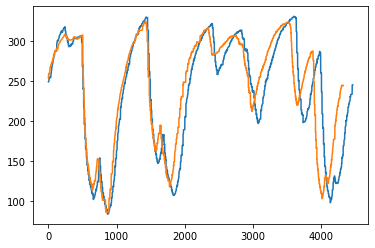

In [40]:
plt.plot(df_ham['Speed'])
plt.plot(df_ham_2['Speed'])
plt.show()

# Check patterns

In [41]:
interval = 50

df_ham['Acc'] = ((df_ham['Speed']-
                  df_ham['Speed'].shift(interval))>0).astype(int)

df_ham['Acc_Ac'] = df_ham['Acc'].rolling(interval).sum()

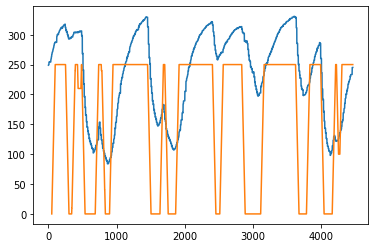

In [42]:
plt.plot(df_ham['Speed'])
plt.plot(df_ham['Acc_Ac']*5)

In [43]:
filter_acc = df_ham['Acc_Ac']>=interval/2
df_ham.loc[filter_acc, 'Acc_Stage'] = 'Acc'
df_ham.loc[filter_acc==False, 'Acc_Stage'] = 'Dec'

df_ham['Acc_Stage_Chg'] = (
    df_ham['Acc_Stage']!=df_ham['Acc_Stage'].shift(1)
    ).astype(int)
    
df_ham['Acc_Stage_#'] = df_ham['Acc_Stage_Chg'].expanding().sum()

df_ham.head()

,Speed,Time,Distance,Acc,Acc_Ac,Acc_Stage,Acc_Stage_Chg,Acc_Stage_#
0,249.0,0.00,0.000000,0,NaN,Dec,1,1.0
1,249.1,0.02,1.383611,0,NaN,Dec,0,1.0
2,249.2,0.04,2.767778,0,NaN,Dec,0,1.0
3,249.3,0.06,4.152500,0,NaN,Dec,0,1.0
4,249.4,0.08,5.537778,0,NaN,Dec,0,1.0


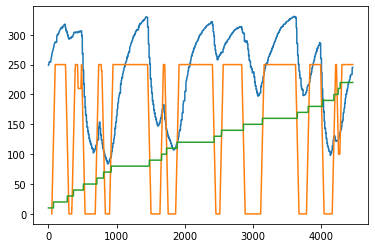

In [46]:
plt.plot(df_ham['Speed'])
plt.plot(df_ham['Acc_Ac']*5)
plt.plot(df_ham['Acc_Stage_#']*10)

In [48]:
df_ham.groupby(['Acc_Stage_#','Acc_Stage']).agg({
    'Speed':[min,max]}).reset_index()

Acc_Stage_# Acc_Stage   Speed        
                             min     max
0          1.0       Dec  249.00  277.20
1          2.0       Acc  277.30  317.70
2          3.0       Dec  293.00  304.11
3          4.0       Acc  240.00  306.29
4          5.0       Dec  102.00  240.90
5          6.0       Acc  105.00  153.90
6          7.0       Dec   84.00  105.70
7          8.0       Acc   97.40  329.90
8          9.0       Dec  147.00  261.90
9         10.0       Acc  142.00  183.17
10        11.0       Dec  107.10  142.90
11        12.0       Acc  119.12  321.90
12        13.0       Dec  258.10  298.21
13        14.0       Acc  270.10  313.53
14        15.0       Dec  197.00  302.90
15        16.0       Acc  221.20  330.90
16        17.0       Dec  198.10  285.39
17        18.0       Acc  209.12  286.90
18        19.0       Dec   98.00  209.21
19        20.0       Acc  122.00  131.50
20        21.0       Dec  123.23  135.90
21        22.0       Acc  135.12  245.21

In [ ]:
def rolling_pipe(dataframe, window, function):
    return pd.Series([dataframe.iloc[i-window: i].pipe(function) 
                      if i >= window else None 
                      for i in range(1, len(dataframe)+1)],
                     index = dataframe.index) 



In [ ]:
df_ham.iloc[100-5: 100]

,Speed,Time,Distance,Acc,Acc_Ac,Last_Ext,Acc_Ac_Chg
95,287.3,1.90,143.465944,1,5.0,5.0,1
96,287.4,1.92,145.062333,1,5.0,5.0,1
97,287.5,1.94,146.659278,1,5.0,5.0,1
98,287.6,1.96,148.256778,1,5.0,5.0,0
99,287.7,1.98,149.854833,1,5.0,5.0,0


In [ ]:
df_ham.pipe(rolling_pipe, 3, lambda x: last_extreme(x, 5, 0))

KeyError: ignored

In [ ]:
df_ham['Acc']

0       0
1       1
2       1
3       1
4       1
       ..
4463    1
4464    1
4465    1
4466    1
4467    1
Name: Acc, Length: 4468, dtype: int64